In [1]:
import rescomp as rc
import numpy as np
from scipy.interpolate import CubicSpline
from scipy import integrate, sparse
from scipy.stats import pearsonr
from scipy.sparse.linalg import eigs, ArpackNoConvergence
from scipy.sparse import coo_matrix
import math 
import networkx as nx
import itertools
import csv
import time
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [20, 5]
# Set seed for reproducibility
np.random.seed(1)
from math import comb
import h5py
from mpi4py import MPI
import traceback
import logging

--------------------------------------------------------------------------

  Local host:   login04
  Local device: mlx5_0
--------------------------------------------------------------------------


### Helper functions

In [2]:
def nrmse(true, pred):
        """ Normalized root mean square error. (A metric for measuring difference in orbits)
        Parameters:
            Two mxn arrays. Axis zero is assumed to be the time axis (i.e. there are m time steps)
        Returns:
            err (ndarray): Error at each time value. 1D array with m entries
        """
        # sig = np.std(true, axis=0)
        # err = np.linalg.norm((true-pred) / sig, axis=1, ord=2)
        err = np.linalg.norm((true-pred), axis=1, ord=2) # Just regular 2-norm
        return err

def valid_prediction_index(err, tol):
    """First index i where err[i] > tol. err is assumed to be 1D and tol is a float. If err is never greater than tol, then len(err) is returned."""
    mask = np.logical_or(err > tol, ~np.isfinite(err))
    if np.any(mask):
        return np.argmax(mask)
    return len(err)

def vpt_time(ts, Uts, pre, vpt_tol=5.):
    """
    Valid prediction time for a specific instance.
    """
    err = nrmse(Uts, pre)
    idx = valid_prediction_index(err, vpt_tol)
    if idx == 0:
        vptime = 0.
    else:
        vptime = ts[idx-1] - ts[0]
    return vptime

def div_metric_tests(preds, T, n):
    """ Compute Diversity scores of predictions
    """
    # Take the derivative of the pred_states
    res_deriv = np.gradient(preds[:T], axis=0)

    # Run the metric for the old and new diversity scores
    div_pos = 0
    div_der = 0
    for i in range(n):
        for j in range(n):
            div_pos += np.sum(np.abs(np.abs(preds[:T, i]) - np.abs(preds[:T, j])))
            div_der += np.sum(np.abs(res_deriv[:T, i] - res_deriv[:T, j]))
    denom = T*comb(n,2)
    div_pos = div_pos / denom
    div_der = div_der / denom

    return div_pos, div_der

def remove_edges(A,n_edges):
    """ Randomly removes 'n_edges' edges from a sparse matrix 'A'
    """
    B = A.copy().todok() # - - - - - - - -  set A as copy

    keys = list(B.keys()) # - - - - remove edges
   
    remove_idx = np.random.choice(range(len(keys)),size=n_edges, replace=False)
    remove = [keys[i] for i in remove_idx]
    for e in remove:
        B[e] = 0
    return B

def pearson_consistency_metric(states, states_perturbed):
    """ Compute the consistency metric for predicted states based on the Echo State Paper - Pearson Correlation Coefficient 
        Parameters:
        ----------
        states: ndarray(T,n)
            States using unperturbed initial state r0. T = time, n = number of nodes

        states_perturbed: ndarray(T,n)
            Perturbed states using perturbed initial state r0. T = time, n = number of nodes

        Returns:
        --------
        aggregated_pearson_correlation_coeff: float 
            The aggregated pearson correlation coefficient between the two response states
    """
    if len(states.shape) == 1:
        return pearsonr(states, states_perturbed)[0]
    else:
        T, n = states.shape
        gammas = np.zeros(n)
        for i in range(n):
            gammas[i] = pearsonr(states[:,i], states_perturbed[:,i])[0]
        # pearsonr is not defined for constant state vectors so nan will be returned - remove these from the array
        aggregated_pearson_correlation_coeff = np.mean(gammas[np.isfinite(gammas)])
        return aggregated_pearson_correlation_coeff

### Tests

In [52]:
t, U = rc.orbit('lorenz', duration=50)
u = CubicSpline(t, U)
t_train = t[:4000]
U_train = u(t[:4000])
t_test = t[4000:]
U_test = u(t[4000:])
eps = 1e-5
tol = 5.

n, erdos_c, gamma, sigma, alpha = 500, 4, 2, 1e-2, 1e-2
n, erdos_c, gamma, sigma, alpha = 500, 4, 16.470072504771654, 0.24581307008326905, 0.00827891588205206

In [56]:
rho = 50.0
p_thin = 0.9

# Generate thinned networks
A_thinned = nx.erdos_renyi_graph(n,erdos_c*(1-p_thin)/(n-1),directed=True)
A_thinned = sparse.dok_matrix(nx.adjacency_matrix(A_thinned).T)
A_thinned_rho = np.max(np.abs(sparse.linalg.eigs(A_thinned.astype(float))[0]))
if A_thinned_rho < 1e-8:
    raise ValueError('Thinned Matrix Spectral Radius too small for scaling')
A_thinned = A_thinned*(rho/np.max(np.abs(sparse.linalg.eigs(A_thinned.astype(float))[0])))

# Run the thinned network
res_thinned = rc.ResComp(A_thinned.tocoo(), res_sz=n, ridge_alpha=alpha, spect_rad=rho, sigma=sigma, gamma=gamma)
res_thinned.train(t_train, U_train)

# t_curr = time_comp(t_curr, f"Train Thinned")

# Calculate Consistency Metric
r0 = res_thinned.initial_condition(U_train[0])
r0_perturbed = r0 + np.random.multivariate_normal(np.zeros(n), np.eye(n)*eps)
states = res_thinned.internal_state_response(t_train, U_train, r0)
states_perturbed = res_thinned.internal_state_response(t_train, U_train, r0_perturbed)
consistency_correlation = pearson_consistency_metric(states, states_perturbed)

# t_curr = time_comp(t_curr, f"States and Consistency Thinned")

# Forecast and compute the vpt along with diversity metrics
U_pred, pred_states = res_thinned.predict(t_test, r0=res_thinned.r0, return_states=True)
error = np.linalg.norm(U_test - U_pred, axis=1)
vpt = vpt_time(t_test, U_test, U_pred, vpt_tol=tol)
divs = div_metric_tests(pred_states, T=len(t_test), n=n)

print(vpt)

/home/seyfdall/.conda/envs/reservoir/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1.6400000000000006


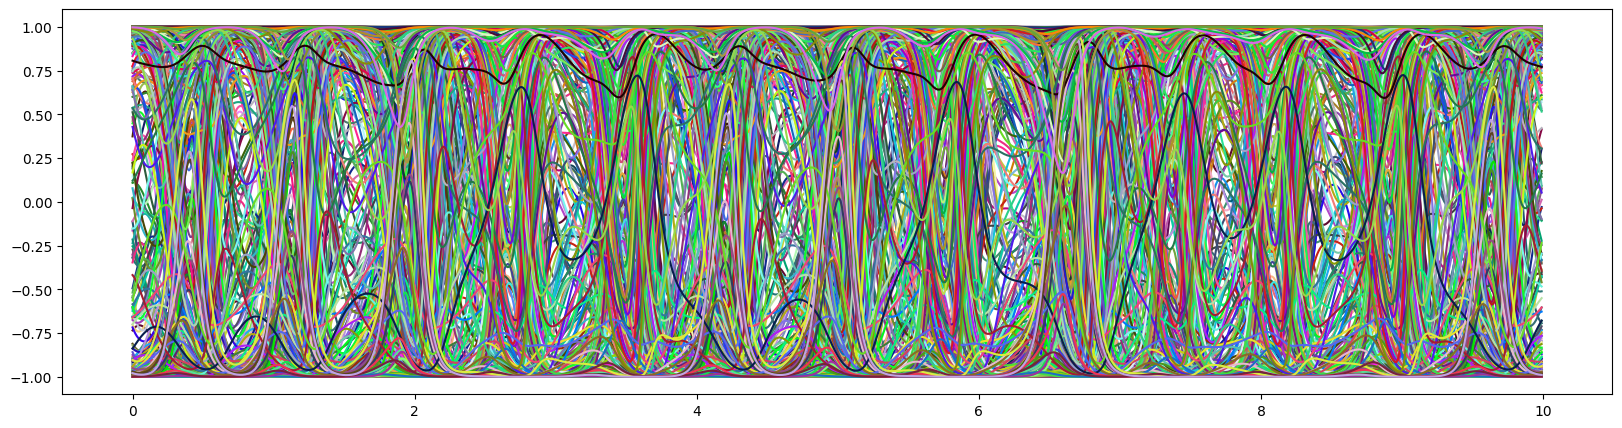

In [54]:
rc.plot2d(t[:1000], pred_states[:1000])
plt.show()

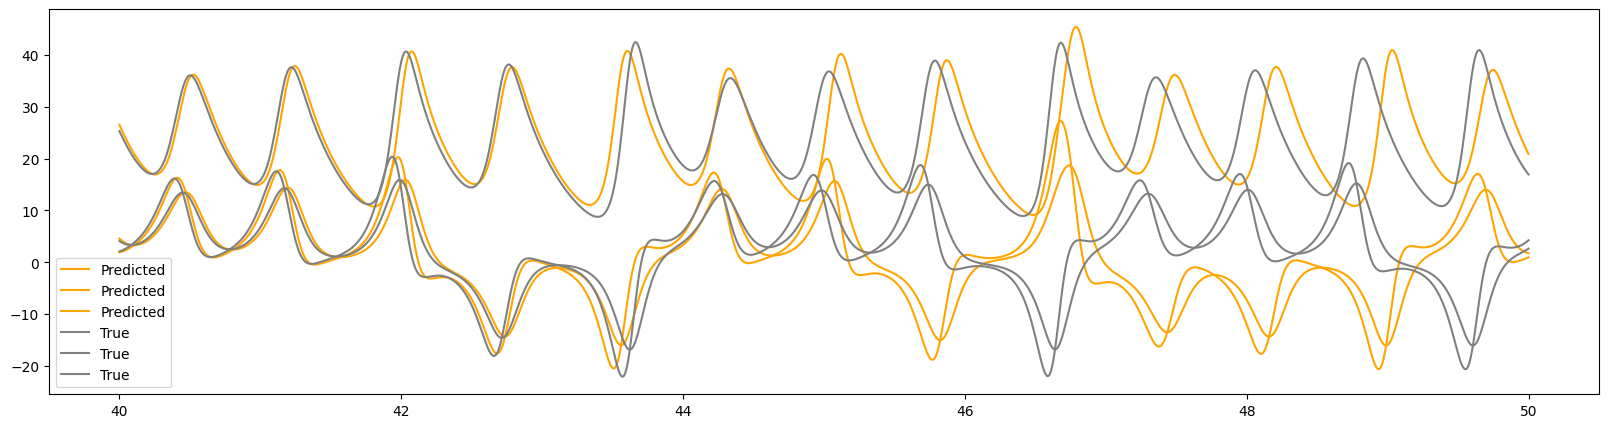

In [55]:
test_t = t[4000:]
plt.plot(test_t, U_pred, c="orange", label="Predicted")
plt.plot(test_t, u(test_t), c="gray", label="True")
plt.legend()
plt.show()